In [2]:
import os
import sys
os.environ['XLA_FLAGS'] = f"--xla_force_host_platform_device_count={os.cpu_count()}"
sys.path.append('../')
from jax import vmap, jit, grad, random, jacfwd
from jax.lax import map
import jax.numpy as jnp
import numpy as np
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import warnings
from jax import config
config.update("jax_enable_x64", True)
import numpyro
numpyro.enable_x64()
from gwb.omega_gw_jax import OmegaGWjax
from interpolation.spline import Spline
from inference.numpyro_model import model
from inference.numpyro_infer import NumpyroInference
from getdist import plots,MCSamples,loadMCSamples
%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True) # if using latex in plots
matplotlib.rc('legend', fontsize=16)


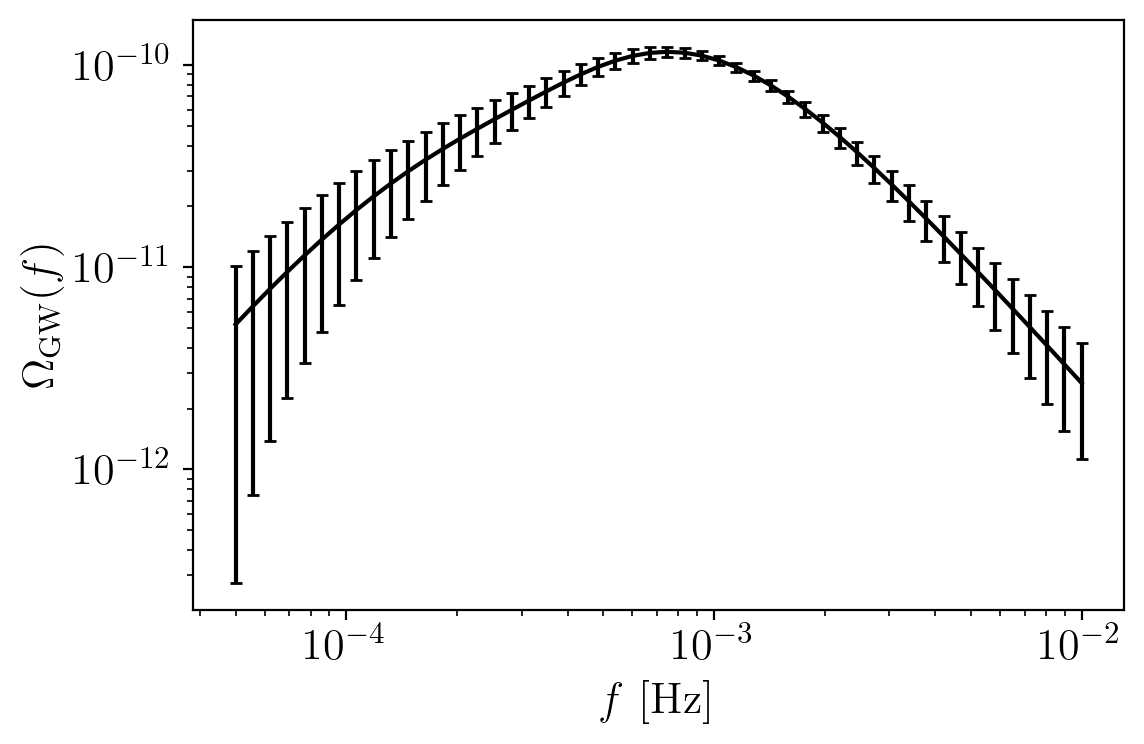

In [3]:
# load the gwb data from file and plot it
data = np.load('../bpl_data.npz')
frequencies = data['k']
Omegas = data['gw']
cov = data['cov']

plt.figure(figsize=(6,4))
plt.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$\Omega_{\rm GW}(f)$')
plt.tight_layout()

In [4]:
# set up the interpolator
fac = 2
pk_min, pk_max = jnp.array(min(frequencies)/5), jnp.array(max(frequencies)*5)
interpolator = Spline(k_min=pk_min, k_max= pk_max,sample_nodes=False,fixed_nodes=None,num_nodes=5)

# set up the gwb calculator
s = jnp.linspace(0, 1, 10)  # First rescaled internal momentum
t = jnp.logspace(-3,3, 100)  # Second rescaled internal momentum
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(frequencies), axis=-1)

gwb_calculator = OmegaGWjax(s,t,frequencies,norm="RD",kernel="RD")



In [5]:
# set up the inference for fixed nodes
num_nodes = 5
fixed_nodes = jnp.linspace(0,1,num_nodes)
model_args = {'num_nodes':num_nodes,  'pk_bounds': [jnp.log10(pk_min),jnp.log10(pk_max)],
              'sample_nodes': False, 'fixed_nodes': fixed_nodes, 'amp_bounds': [-6,-1],
              'interpolator': interpolator, 'gwb_calculator': gwb_calculator,
             }
sampler = NumpyroInference(model,model_args=model_args
                           ,num_samples=512,num_warmup=256,
                          )

samples, extras = sampler.run_inference(frequencies=frequencies,data=Omegas,cov=cov)

sample: 100%|██████████| 768/768 [03:02<00:00,  4.22it/s, 15 steps of size 2.55e-01. acc. prob=0.89] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
 values[0]     -4.70      0.97     -4.89     -5.97     -3.37    137.71      1.01
 values[1]     -3.41      0.10     -3.42     -3.57     -3.22    157.99      1.00
 values[2]     -2.42      0.01     -2.42     -2.43     -2.41    247.05      1.00
 values[3]     -3.12      0.03     -3.12     -3.17     -3.09     71.72      1.01
 values[4]     -3.19      0.45     -3.09     -3.71     -2.64     42.10      1.03

Number of divergences: 0


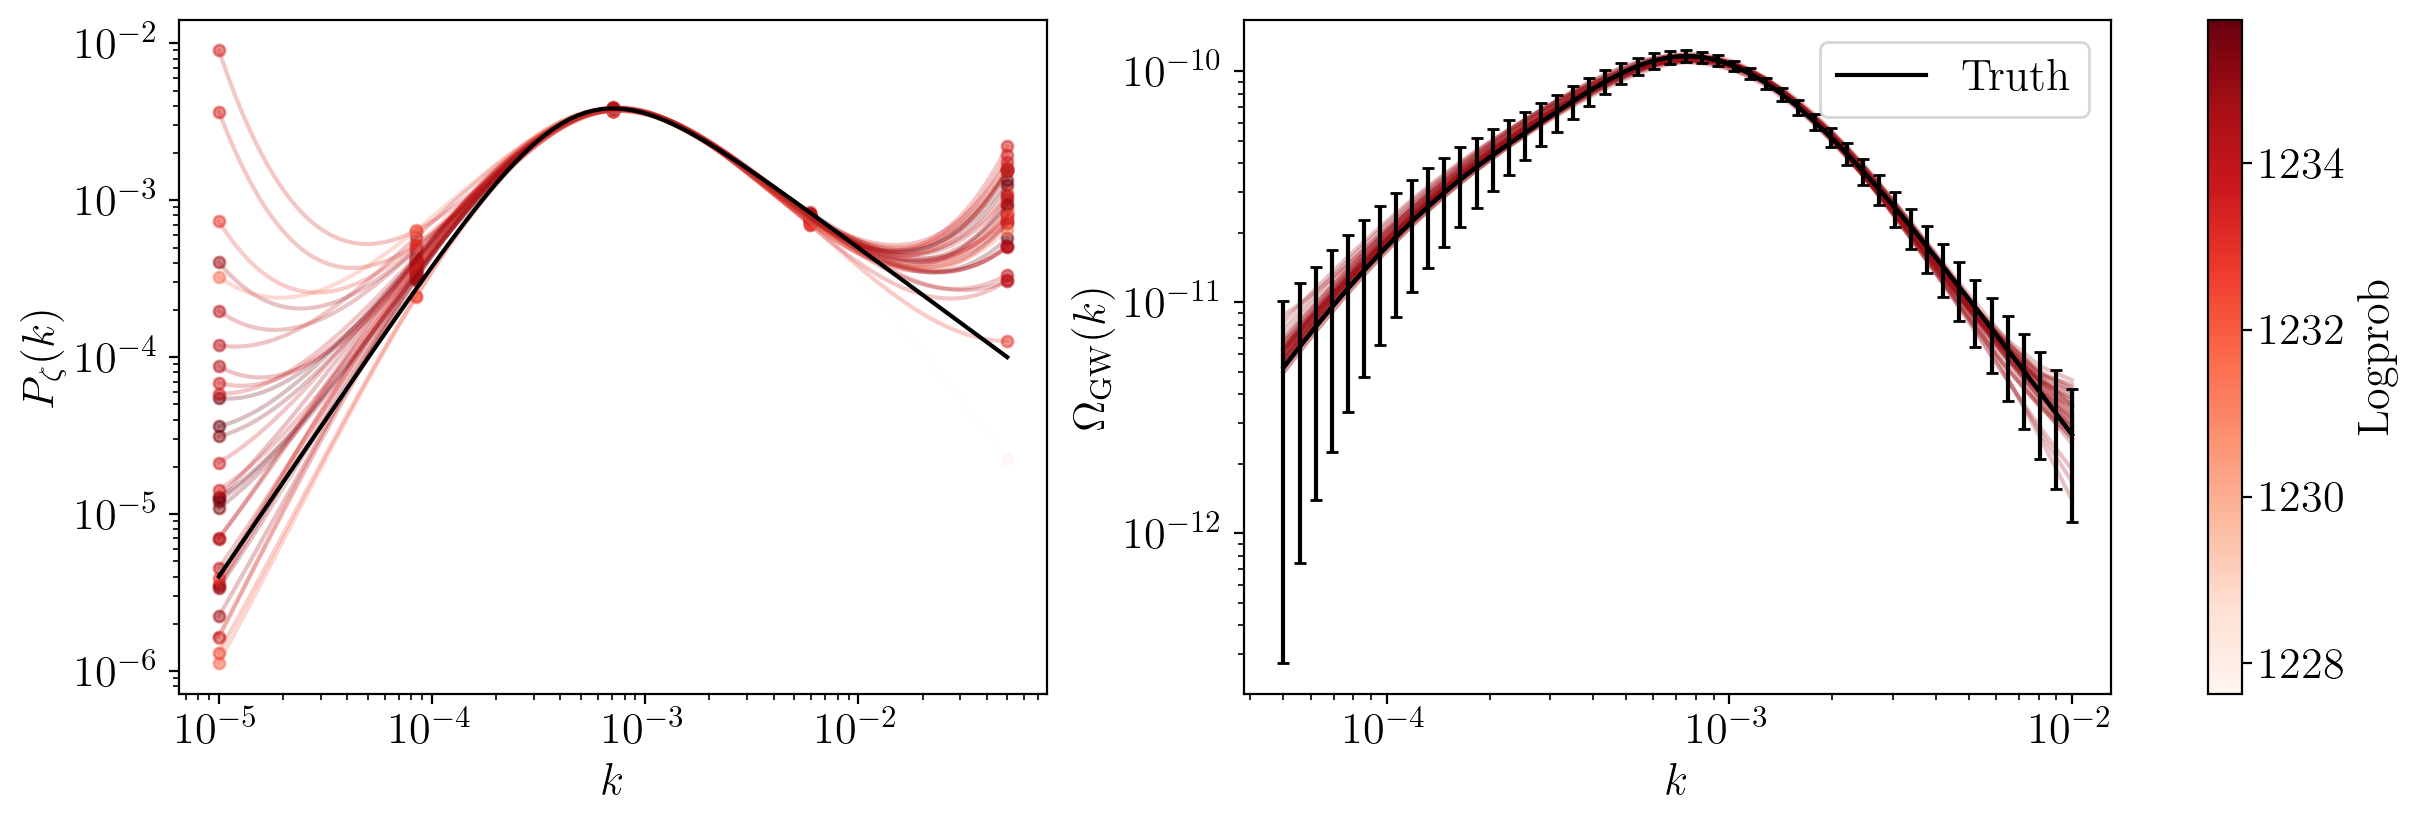

In [6]:
### Plot the MC realisations with their logprob

from interpolation.spline import spline_predict
p_arr = jnp.geomspace(pk_min*1.001,pk_max*0.999,100,endpoint=True)

thinning = 16
cmap = matplotlib.colormaps['Reds']
ys = samples['values'][::thinning]
xs = interpolator.fixed_nodes
lp = -extras["potential_energy"][::thinning] # PE = -logprob
lp_min, lp_max = np.min(lp), np.max(lp)
cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour
norm = colors.Normalize(lp_min,lp_max)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),layout='constrained')

def get_pz_omega(y):
    pf = interpolator.interpolate(xs, y)
    pz_amps = pf(p_arr)
    gwb_res = gwb_calculator(pf,frequencies)
    return pz_amps, gwb_res

pz_amps,gwb_amps = vmap(get_pz_omega)(ys)
# print(pz_amps[2])

for i,ps in enumerate(pz_amps):
    ax1.loglog(p_arr,ps,alpha=0.25,color=cmap(cols[i]))
    ax1.scatter(10**(xs),10**(ys[i]),s=16,alpha=0.5,color=cmap(cols[i]))
for om in gwb_amps:
    ax2.loglog(frequencies,om,alpha=0.25,color=cmap(cols[i]))

# True pz
def pz(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    return 1e-2 * pl1 * pl2
pz_amp = pz(p_arr)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.loglog(frequencies,Omegas,color='k',lw=1.5,label='Truth')

ax2.legend()
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2],label='Logprob')

In [7]:
# # inference for free nodes
# num_nodes = 4
# interpolator = Spline(k_min=pk_min, k_max= pk_max,sample_nodes=True,fixed_nodes=None,num_nodes=num_nodes)
# model_args = {'num_nodes':num_nodes,  'pk_bounds': [jnp.log10(pk_min),jnp.log10(pk_max)],
#               'sample_nodes': True, 'fixed_nodes': None, 'amp_bounds': [-6,-1],
#               'interpolator': interpolator, 'gwb_calculator': gwb_calculator,
#              }
# sampler = NumpyroInference(model,model_args=model_args
#                            ,num_samples=512,num_warmup=256,
#                           )

# samples, extras = sampler.run_inference(frequencies=frequencies,data=Omegas,cov=cov)

# too slow

In [8]:
# ### Plot the MC realisations with their logprob

# from interpolation.spline import spline_predict
# p_arr = jnp.geomspace(pk_min*1.001,pk_max*0.999,100,endpoint=True)

# thinning = 16
# cmap = matplotlib.colormaps['Reds']
# ys = samples['values'][::thinning]
# xs = samples['nodes'][::thinning]
# lp = -extras["potential_energy"][::thinning] # PE = -negative logprob
# lp_min, lp_max = np.min(lp), np.max(lp)
# cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour
# norm = colors.Normalize(lp_min,lp_max)

# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),layout='constrained')

# def get_pz_omega(x,y):
#     pz = interpolator.interpolate(x, y)
#     pz_amps = pz(p_arr)
#     gwb_res = gwb_calculator(pz,frequencies)
#     return pz_amps, gwb_res

# pz_amps,gwb_amps = vmap(get_pz_omega)(xs,ys)

# for i,pz in enumerate(pz_amps):
#     ax1.loglog(p_arr,pz,alpha=0.25,color=cmap(cols[i]))
#     ax1.scatter(10**(xs[i]),10**(ys[i]),s=16,alpha=0.5,color=cmap(cols[i]))
# for om in gwb_amps:
#     ax2.loglog(frequencies,om,alpha=0.25,color=cmap(cols[i]))

# # True pz
# def pz(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
#     nir = n1
#     pl1 = (p/pstar)**nir
#     nuv = (n2 - n1)/sigma
#     pl2 = (1+(p/pstar)**sigma)**nuv
#     return 1e-2 * pl1 * pl2
# pz_amp = pz(p_arr)
# ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
# ax2.loglog(frequencies,Omegas,color='k',lw=1.5,label='Truth')

# ax2.legend()
# ax1.set_ylabel(r'$P_{\zeta}(k)$')
# ax1.set_xlabel(r'$k$')
# ax2.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')

# ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
# ax2.set_xlabel(r'$k$')
# fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2],label='Logprob')

In [15]:
# now test with jaxns
import tensorflow_probability.substrates.jax as tfp
from jaxns import NestedSampler
from jaxns import Model, Prior
from jaxns.framework.special_priors import ForcedIdentifiability
tfpd = tfp.distributions


num_nodes = 4
pk_min, pk_max = jnp.array(min(frequencies)/5), jnp.array(max(frequencies)*5)
interpolator = Spline(k_min=pk_min, k_max= pk_max,sample_nodes=True,fixed_nodes=None,num_nodes=num_nodes)

def prior():
    x = yield ForcedIdentifiability(n=num_nodes, low=jnp.log10(pk_min), high=jnp.log10(pk_max), name='x',fix_left=True,fix_right=True)
    y = yield Prior(tfpd.Uniform(low=-6*jnp.ones(num_nodes), high=-jnp.ones(num_nodes)), name='y')
    return x, y

def likelihood(x, y):
    pf = interpolator.interpolate(x,y)
    gwb = gwb_calculator(pf,frequencies)
    return tfp.distributions.Normal(gwb, jnp.sqrt(jnp.diag(cov))).log_prob(Omegas).sum()

model = Model(prior, likelihood)
model.sanity_check(key=random.PRNGKey(0),S=100)

INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


In [16]:
exact_ns = NestedSampler(model=model, max_samples=1e5,parameter_estimation=True,verbose=True)

termination_reason, state = exact_ns(random.PRNGKey(42))
results = exact_ns.to_results(termination_reason=termination_reason, state=state)
exact_ns.summary(results)

Running over 8 devices.
Creating initial state with 192 live points.
Running uniform sampling down to efficiency threshold of 0.1.
Running until termination condition: TerminationCondition(ess=None, evidence_uncert=None, live_evidence_frac=None, dlogZ=None, max_samples=Array(100128, dtype=int64), max_num_likelihood_evaluations=None, log_L_contour=None, efficiency_threshold=None, rtol=None, atol=None, peak_XL_frac=Array(0.1, dtype=float64))
-------
Num samples: 672
Num likelihood evals: 3605
Efficiency: 0.05180787911494873
log(L) contour: -147758098.94575962
log(Z) est.: 786.371533061212 +- 0.8309972896424747
log(Z | remaining) est.: 147758892.11190248 +- 1.1751962133543603
ESS: 0.5012970219457314

-------
Num samples: 1344
Num likelihood evals: 7879
Efficiency: 0.031496062992125984
log(L) contour: -929.817467834807
log(Z) est.: 953.4193062922378 +- 0.8325465634933831
log(Z | remaining) est.: 1890.5216427994546 +- 1.1757371668138172
ESS: 0.5000067001325431

-------
Num samples: 2016
Num

In [17]:
exact_ns.plot_diagnostics(results)

/opt/homebrew/Caskroom/miniforge/base/envs/cosmo/lib/python3.12/site-packages/jaxns/plotting.py:45: UserWarning: Found samples with zero likelihood evaluations.
  warnings.warn("Found samples with zero likelihood evaluations.")
/opt/homebrew/Caskroom/miniforge/base/envs/cosmo/lib/python3.12/site-packages/matplotlib/ticker.py:2176: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
/opt/homebrew/Caskroom/miniforge/base/envs/cosmo/lib/python3.12/site-packages/matplotlib/ticker.py:2027: RuntimeWarning: overflow encountered in scalar divmod
  d, m = divmod(x, self.step)
/opt/homebrew/Caskroom/miniforge/base/envs/cosmo/lib/python3.12/site-packages/matplotlib/ticker.py:2218: RuntimeWarning: overflow encountered in scalar subtract
  high = edge.ge(_vmax - best_vmin)


ValueError: arange: cannot compute length

<Figure size 800x1500 with 6 Axes>

/opt/homebrew/Caskroom/miniforge/base/envs/cosmo/lib/python3.12/site-packages/jaxns/plotting.py:209: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(per_1, per_99)
/opt/homebrew/Caskroom/miniforge/base/envs/cosmo/lib/python3.12/site-packages/jaxns/plotting.py:209: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(per_1, per_99)
/opt/homebrew/Caskroom/miniforge/base/envs/cosmo/lib/python3.12/site-packages/jaxns/plotting.py:257: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(param_limits[parameters[col]])
/opt/homebrew/Caskroom/miniforge/base/envs/cosmo/lib/python3.12/site-packages/jaxns/plotting.py:258: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(param_limits[pa

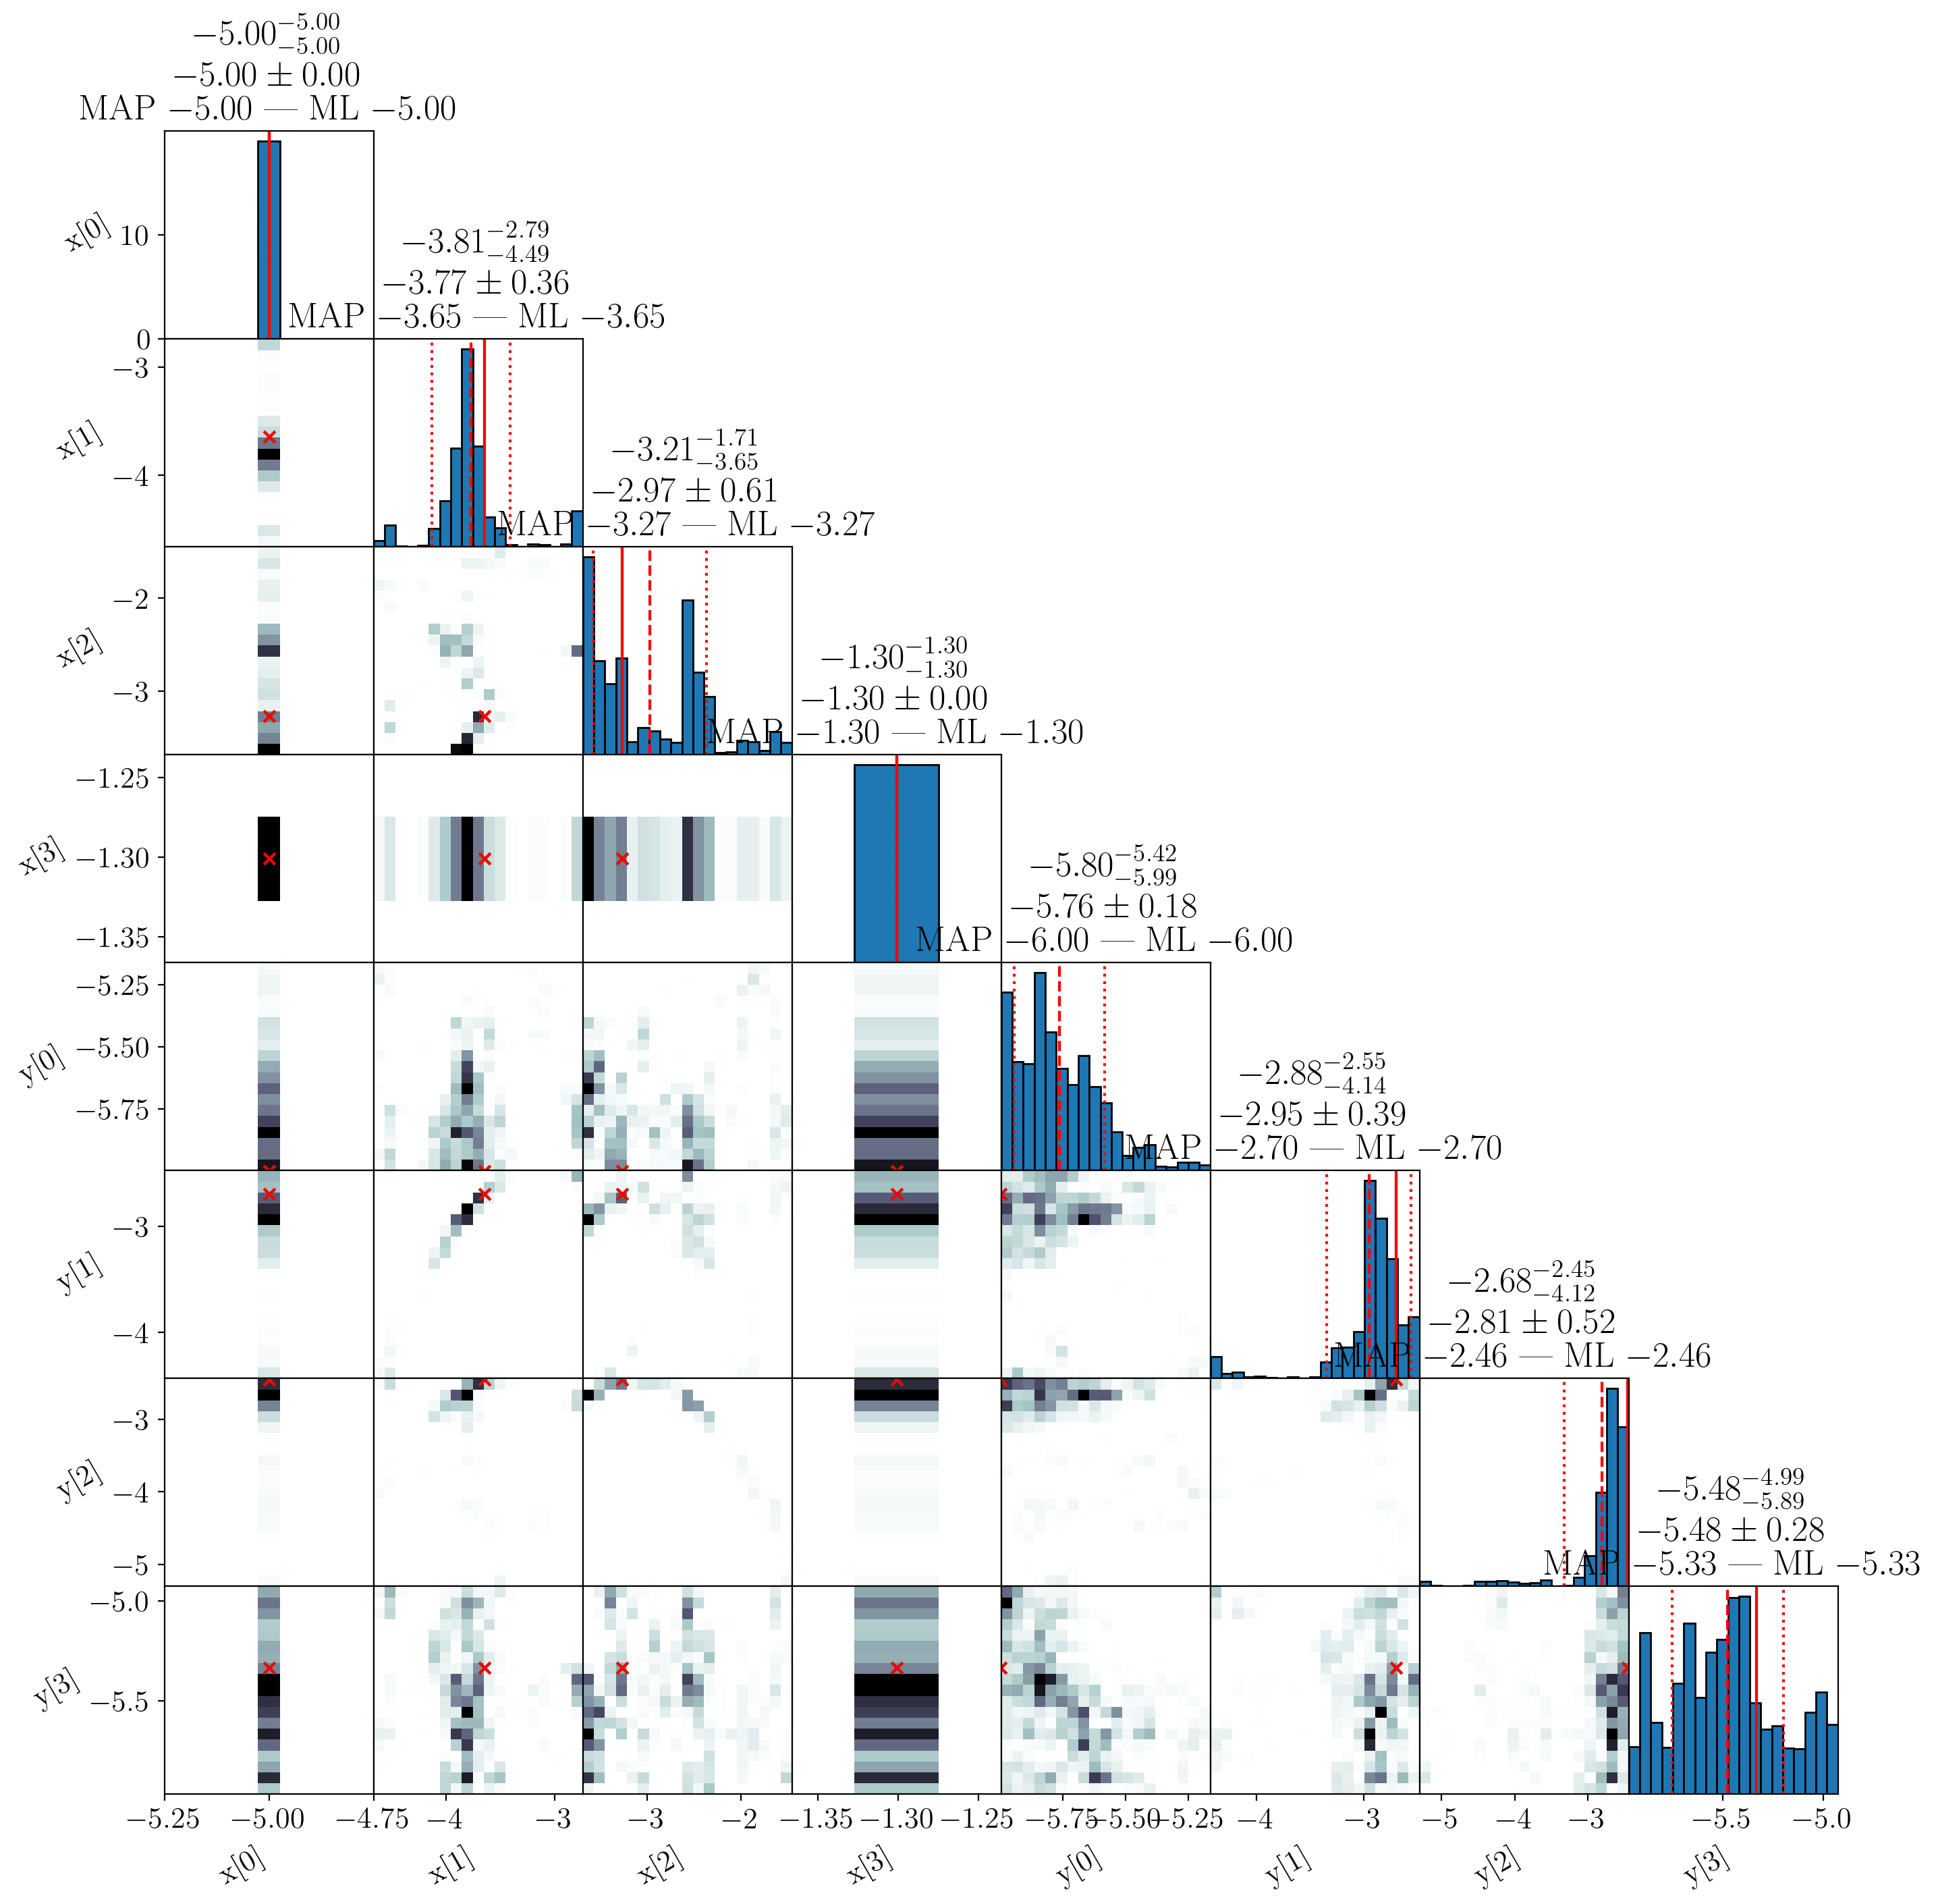

In [18]:
exact_ns.plot_cornerplot(results)

In [22]:
from jaxns import resample
samples =  resample(key=random.PRNGKey(0),
                        samples=results.samples,
                        log_weights=results.log_dp_mean, # type: ignore
                        replace=True,) 
print(samples.keys())
print(samples['x'].shape)

dict_keys(['x', 'y'])
(5024, 4)


Text(0.5, 0, '$k$')

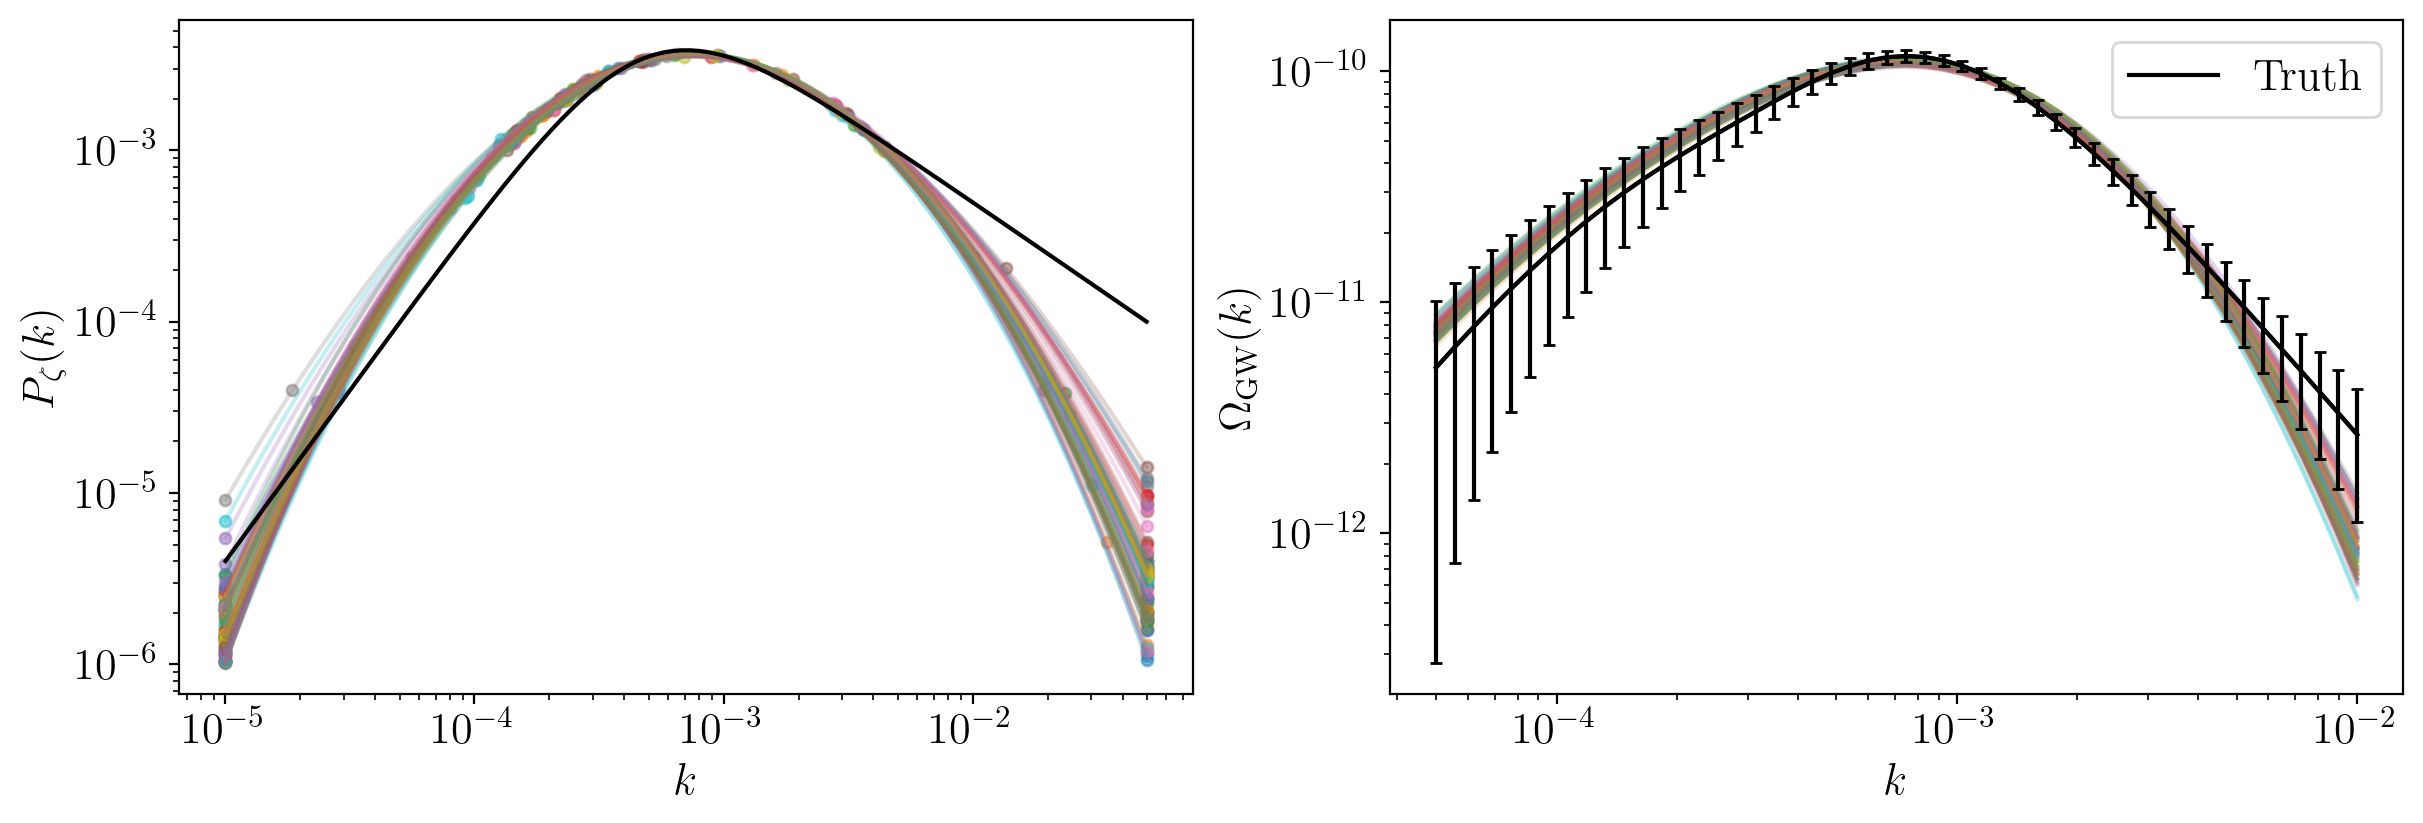

In [24]:
### Plot the MC realisations with their logprob

from interpolation.spline import spline_predict
p_arr = jnp.geomspace(pk_min*1.001,pk_max*0.999,100,endpoint=True)

thinning = 64
cmap = matplotlib.colormaps['Reds']
ys = samples['y'][::thinning]
xs = samples['x'][::thinning]
# lp = -extras["potential_energy"][::thinning] # PE = -negative logprob
# lp_min, lp_max = np.min(lp), np.max(lp)
# cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour
# norm = colors.Normalize(lp_min,lp_max)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),layout='constrained')

def get_pz_omega(x,y):
    pz = interpolator.interpolate(x, y)
    pz_amps = pz(p_arr)
    gwb_res = gwb_calculator(pz,frequencies)
    return pz_amps, gwb_res

pz_amps,gwb_amps = vmap(get_pz_omega)(xs,ys)

for i,pz in enumerate(pz_amps):
    ax1.loglog(p_arr,pz,alpha=0.25)#,color=cmap(cols[i]))
    ax1.scatter(10**(xs[i]),10**(ys[i]),s=16,alpha=0.5)#,color=cmap(cols[i]))
for om in gwb_amps:
    ax2.loglog(frequencies,om,alpha=0.25)#,color=cmap(cols[i]))

# True pz
def pz(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    return 1e-2 * pl1 * pl2
pz_amp = pz(p_arr)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.loglog(frequencies,Omegas,color='k',lw=1.5,label='Truth')

ax2.legend()
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
# fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2],label='Logprob')